# Project 7: Combine Signals for Enhanced Alpha
## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. After implementing the function, run the cell to test it against the unit tests we've provided. For each problem, we provide one or more unit tests from our `project_tests` package. These unit tests won't tell you if your answer is correct, but will warn you of any major errors. Your code will be checked for the correct solution when you submit it to Udacity.

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `project_helper` and `project_tests`. These are custom packages built to help you solve the problems.  The `project_helper` module contains utility functions and graph functions. The `project_tests` contains the unit tests for all the problems.

### Install Packages

In [1]:
#import sys
#!{sys.executable} -m pip install -r requirements.txt

### Load Packages

In [ ]:
import project_helper
import project_tests

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

## Data Pipeline
### Data Bundle
We'll be using Zipline to handle our data. We've created a end of day data bundle for this project. Run the cell below to register this data bundle in zipline.

In [3]:
import os
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..', 'data', 'project_7_eod')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], project_helper.EOD_BUNDLE_NAME)
bundles.register(project_helper.EOD_BUNDLE_NAME, ingest_func)

print('Data Registered')

Data Registered


### Build Pipeline Engine
We'll be using Zipline's pipeline package to access our data for this project. To use it, we must build a pipeline engine. Run the cell below to build the engine.

In [4]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar


universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(project_helper.EOD_BUNDLE_NAME)
engine = project_helper.build_pipeline_engine(bundle_data, trading_calendar)

#### View Data
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using.

In [5]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

In [6]:
len(universe_tickers)

490

### Get Returns
Not that we have our pipeline built, let's access the returns data. We'll start by building a data portal.

In [6]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [7]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

# Alpha Factors
It's time to start working on the alpha factors. In this project, we'll use the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Smoothed Factor

In [8]:
from zipline.pipeline.factors import CustomFactor, DailyReturns, Returns, SimpleMovingAverage, AnnualizedVolatility
from zipline.pipeline.data import USEquityPricing


factor_start_date = universe_end_date - pd.DateOffset(years=3, days=2)
sector = project_helper.Sector()

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    unsmoothed_factor = -Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=window_length) \
        .rank() \
        .zscore()

class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]
        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    unsmoothed_factor = TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

### Combine the Factors to a single Pipeline
Let's add the factors to a pipeline.

In [9]:
universe = AverageDollarVolume(window_length=120).top(500)
sector = project_helper.Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(20, universe, sector),
    'Mean_Reversion_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment_smoothed(2, 10, universe),
    'Overnight_Sentiment_Smoothed')

## Features and Labels
Let's create some features that we think will help the model make predictions.
### "Universal" Quant Features
To capture the universe, we'll use the following as features:
- Stock Volatility 20d, 120d
- Stock Dollar Volume 20d, 120d
- Sector

In [10]:
pipeline.add(AnnualizedVolatility(window_length=20, mask=universe).rank().zscore(), 'volatility_20d')
pipeline.add(AnnualizedVolatility(window_length=120, mask=universe).rank().zscore(), 'volatility_120d')
pipeline.add(AverageDollarVolume(window_length=20, mask=universe).rank().zscore(), 'adv_20d')
pipeline.add(AverageDollarVolume(window_length=120, mask=universe).rank().zscore(), 'adv_120d')
pipeline.add(sector, 'sector_code')

### Regime Features
We are going to try to capture market-wide regimes. To do that, we'll use the following features:
- High and low volatility 20d, 120d
- High and low dispersion 20d, 120d

In [11]:
class MarketDispersion(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True

    def compute(self, today, assets, out, returns):
        # returns are days in rows, assets across columns
        out[:] = np.sqrt(np.nanmean((returns - np.nanmean(returns))**2))


pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=20), 'dispersion_20d')
pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=120), 'dispersion_120d')

In [12]:
class MarketVolatility(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True
    
    def compute(self, today, assets, out, returns):
        mkt_returns = np.nanmean(returns, axis=1)
        out[:] = np.sqrt(260.* np.nanmean((mkt_returns-np.nanmean(mkt_returns))**2))


pipeline.add(MarketVolatility(window_length=20), 'market_vol_20d')
pipeline.add(MarketVolatility(window_length=120), 'market_vol_120d')

### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

In [13]:
pipeline.add(Returns(window_length=5, mask=universe).quantiles(2), 'return_5d')
pipeline.add(Returns(window_length=5, mask=universe).quantiles(25), 'return_5d_p')

### Date Features
Let's make columns for the trees to split on that might capture trader/investor behavior due to calendar anomalies.

In [14]:
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors['is_Janaury'] = all_factors.index.get_level_values(0).month == 1
all_factors['is_December'] = all_factors.index.get_level_values(0).month == 12
all_factors['weekday'] = all_factors.index.get_level_values(0).weekday
all_factors['quarter'] = all_factors.index.get_level_values(0).quarter
all_factors['qtr_yr'] = all_factors.quarter.astype('str') + '_' + all_factors.index.get_level_values(0).year.astype('str')
all_factors['month_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BM'))
all_factors['month_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BMS'))
all_factors['qtr_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQ'))
all_factors['qtr_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQS'))

all_factors.head()

Mean_Reversion_Sector_Neutral_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                                -0.26276899   
                          Equity(1 [AAL])                               0.09992624   
                          Equity(2 [AAP])                               1.66913824   
                          Equity(3 [AAPL])                              1.69874602   
                          Equity(4 [ABBV])                                     nan   

                                            Momentum_1YR  \
2013-01-03 00:00:00+00:00 Equity(0 [A])      -1.20797813   
                          Equity(1 [AAL])     1.71347052   
                          Equity(2 [AAP])    -1.53506144   
                          Equity(3 [AAPL])    1.19311071   
                          Equity(4 [ABBV])           nan   

                                            Overnight_Sentiment_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                      -1.48566901   
                          Equity(1 [AAL])                     0.91934963   
                          Equity(2 [AAP])                     1.50773340   
                          Equity(3 [AAPL])                   -1.36799226   
                          Equity(4 [ABBV])                   -0.25006310   

                                              adv_120d     adv_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])     1.33857307  1.39741144   
                          Equity(1 [AAL])   1.13999355  1.08115517   
                          Equity(2 [AAP])  -0.30154668 -0.91934963   
                          Equity(3 [AAPL])  1.72837731  1.72837731   
                          Equity(4 [ABBV]) -1.72837731 -1.64747455   

                                            dispersion_120d  dispersion_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])          0.01326964      0.01117804   
                          Equity(1 [AAL])        0.01326964      0.01117804   
                          Equity(2 [AAP])        0.01326964      0.01117804   
                          Equity(3 [AAPL])       0.01326964      0.01117804   
                          Equity(4 [ABBV])       0.01459524      0.01459524   

                                            market_vol_120d  market_vol_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])          0.12966421      0.13758558   
                          Equity(1 [AAL])        0.12966421      0.13758558   
                          Equity(2 [AAP])        0.12966421      0.13758558   
                          Equity(3 [AAPL])       0.12966421      0.13758558   
                          Equity(4 [ABBV])       0.12966421      0.13758558   

                                            return_5d    ...     \
2013-01-03 00:00:00+00:00 Equity(0 [A])             0    ...      
                          Equity(1 [AAL])           1    ...      
                          Equity(2 [AAP])           0    ...      
                          Equity(3 [AAPL])          1    ...      
                          Equity(4 [ABBV])         -1    ...      

                                            volatility_20d  is_Janaury  \
2013-01-03 00:00:00+00:00 Equity(0 [A])        -1.21980876        True   
                          Equity(1 [AAL])       1.56621970        True   
                          Equity(2 [AAP])      -1.47040391        True   
                          Equity(3 [AAPL])      1.61781282        True   
                          Equity(4 [ABBV])             nan        True   

                                            is_December  weekday quarter  \
2013-01-03 00:00:00+00:00 Equity(0 [A])           False        3       1   
                          Equity(1 [AAL])         False        3       1   
                          Equity(2 [AAP])         False        3       1   
                          Equity(3 [AAPL])        False        3       1   
                          Equity(4 [ABBV])        False        3       1   

                                 

In [15]:
all_factors.tail(2)

Mean_Reversion_Sector_Neutral_Smoothed  \
2016-01-05 00:00:00+00:00 Equity(489 [ZION])                              1.39348416   
                          Equity(490 [ZTS])                              -0.58091539   

                                              Momentum_1YR  \
2016-01-05 00:00:00+00:00 Equity(489 [ZION])   -0.13351254   
                          Equity(490 [ZTS])     0.31393489   

                                              Overnight_Sentiment_Smoothed  \
2016-01-05 00:00:00+00:00 Equity(489 [ZION])                    0.81653994   
                          Equity(490 [ZTS])                    -0.04595246   

                                                adv_120d     adv_20d  \
2016-01-05 00:00:00+00:00 Equity(489 [ZION]) -0.99328018 -0.68221735   
                          Equity(490 [ZTS])   0.19441427 -0.16613583   

                                              dispersion_120d  dispersion_20d  \
2016-01-05 00:00:00+00:00 Equity(489 [ZION])       0.01490814      0.01423245   
                          Equity(490 [ZTS])        0.01490814      0.01423245   

                                              market_vol_120d  market_vol_20d  \
2016-01-05 00:00:00+00:00 Equity(489 [ZION])       0.18557429      0.17955718   
                          Equity(490 [ZTS])        0.18557429      0.17955718   

                                              return_5d    ...     \
2016-01-05 00:00:00+00:00 Equity(489 [ZION])          0    ...      
                          Equity(490 [ZTS])           1    ...      

                                              volatility_20d  is_Janaury  \
2016-01-05 00:00:00+00:00 Equity(489 [ZION])      1.14174199        True   
                          Equity(490 [ZTS])      -1.17709004        True   

                                              is_December  weekday quarter  \
2016-01-05 00:00:00+00:00 Equity(489 [ZION])        False        1       1   
                          Equity(490 [ZTS])         False        1       1   

                                              qtr_yr  month_end  month_start  \
2016-01-05 00:00:00+00:00 Equity(489 [ZION])  1_2016      False        False   
                          Equity(490 [ZTS])   1_2016      False        False   

                                             qtr_end qtr_start  
2016-01-05 00:00:00+00:00 Equity(489 [ZION])   False     False  
                          Equity(490 [ZTS])    False     False  

[2 rows x 23 columns]

In [16]:
# These numbers suggest the number of stocks changes over time - suvivorship bias???
num_dates = len(all_factors.index.levels[0].tolist())
num_stocks = len(all_factors.index.levels[1].tolist())
print('all_factors:\t', len(all_factors))
print('Num dates:\t', num_dates)
print('Num stocks:\t', num_stocks)
print('all / dates:\t', len(all_factors)/num_dates)
print('all / stocks:\t', len(all_factors)/num_stocks)

all_factors:	 363734
Num dates:	 757
Num stocks:	 490
all / dates:	 480.49405548216646
all / stocks:	 742.3142857142857


### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

In [17]:
sector_lookup = pd.read_csv(
    os.path.join(os.getcwd(), '..', '..', 'data', 'project_7_sector', 'labels.csv'),
    index_col='Sector_i')['Sector'].to_dict()
sector_lookup

sector_columns = []
for sector_i, sector_name in sector_lookup.items():
    secotr_column = 'sector_{}'.format(sector_name)
    sector_columns.append(secotr_column)
    all_factors[secotr_column] = (all_factors['sector_code'] == sector_i)

all_factors[sector_columns].head()

sector_Healthcare  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                 True   
                          Equity(1 [AAL])              False   
                          Equity(2 [AAP])              False   
                          Equity(3 [AAPL])             False   
                          Equity(4 [ABBV])              True   

                                           sector_Technology  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                False   
                          Equity(1 [AAL])              False   
                          Equity(2 [AAP])              False   
                          Equity(3 [AAPL])              True   
                          Equity(4 [ABBV])             False   

                                           sector_Consumer Defensive  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                        False   
                          Equity(1 [AAL])                      False   
                          Equity(2 [AAP])                      False   
                          Equity(3 [AAPL])                     False   
                          Equity(4 [ABBV])                     False   

                                           sector_Industrials  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                 False   
                          Equity(1 [AAL])                True   
                          Equity(2 [AAP])               False   
                          Equity(3 [AAPL])              False   
                          Equity(4 [ABBV])              False   

                                           sector_Utilities  \
2013-01-03 00:00:00+00:00 Equity(0 [A])               False   
                          Equity(1 [AAL])             False   
                          Equity(2 [AAP])             False   
                          Equity(3 [AAPL])            False   
                          Equity(4 [ABBV])            False   

                                           sector_Financial Services  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                        False   
                          Equity(1 [AAL])                      False   
                          Equity(2 [AAP])                      False   
                          Equity(3 [AAPL])                     False   
                          Equity(4 [ABBV])                     False   

                                           sector_Real Estate  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                 False   
                          Equity(1 [AAL])               False   
                          Equity(2 [AAP])               False   
                          Equity(3 [AAPL])              False   
                          Equity(4 [ABBV])              False   

                                           sector_Communication Services  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                            False   
                          Equity(1 [AAL])                          False   
                          Equity(2 [AAP])                          False   
                          Equity(3 [AAPL])                         False   
                          Equity(4 [ABBV])                         False   

                                           sector_Consumer Cyclical  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                       False   
                          Equity(1 [AAL])                     False   
                          Equity(2 [AAP])                      True   
                          Equity(3 [AAPL])                    False   
                          Equity(4 [ABBV])                    False   

                                           sector_Energy  \
2013-01-03 00:00:00+00:00 Equity(0 [A])            False   
                          Equity(1 [AAL])          False   
                          Equity(2 [AAP])          False   
                          Equity(3 [AAPL])         False   
                          Equity(4 [ABBV])         False   

 

### Shift Target
We'll use shifted 5 day returns for training the model.

In [18]:
all_factors['target'] = all_factors.groupby(level=1)['return_5d'].shift(-5)

all_factors[['return_5d','target']].reset_index().sort_values(['level_1', 'level_0']).head(10)

,level_0,level_1,return_5d,target
0,2013-01-03 00:00:00+00:00,Equity(0 [A]),0,0.00000000
471,2013-01-04 00:00:00+00:00,Equity(0 [A]),0,0.00000000
942,2013-01-07 00:00:00+00:00,Equity(0 [A]),0,0.00000000
1413,2013-01-08 00:00:00+00:00,Equity(0 [A]),0,1.00000000
1884,2013-01-09 00:00:00+00:00,Equity(0 [A]),0,0.00000000
2355,2013-01-10 00:00:00+00:00,Equity(0 [A]),0,0.00000000
2826,2013-01-11 00:00:00+00:00,Equity(0 [A]),0,0.00000000
3297,2013-01-14 00:00:00+00:00,Equity(0 [A]),0,0.00000000
3768,2013-01-15 00:00:00+00:00,Equity(0 [A]),1,0.00000000
4239,2013-01-16 00:00:00+00:00,Equity(0 [A]),0,0.00000000


### IID Check of Target
Let's see if the returns are independent and identically distributed.

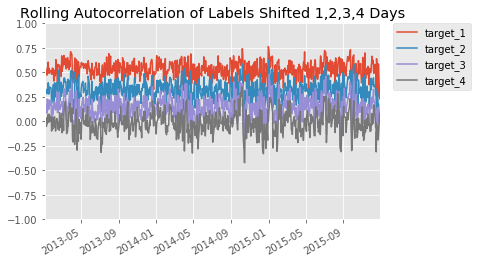

In [19]:
from scipy.stats import spearmanr


def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]


all_factors['target_p'] = all_factors.groupby(level=1)['return_5d_p'].shift(-5)
all_factors['target_1'] = all_factors.groupby(level=1)['return_5d'].shift(-4)
all_factors['target_2'] = all_factors.groupby(level=1)['return_5d'].shift(-3)
all_factors['target_3'] = all_factors.groupby(level=1)['return_5d'].shift(-2)
all_factors['target_4'] = all_factors.groupby(level=1)['return_5d'].shift(-1)

g = all_factors.dropna().groupby(level=0)
for i in range(4):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, 'target', label)
    ic.plot(ylim=(-1, 1), label=label)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()

### Question: What do you observe in the rolling autocorrelation of labels shifted?
*#TODO: Put Answer In this Cell.*  

The further into the future, the less autocorrelated the targets are (eg: target_4 is predicting 4 days in the future and has an average autocorrelation around zero, vs target_1 which has an autocorrelation in the 0.5 to 0.7 range, which is better but still not great). This means the further out we try to predict, the more transient and unstable the factors will be, resulting in higher turnover/trading and potential false signals. Plus they are all fairly unstable with low autocorrelations.


### Train/Valid/Test Splits
Now let's split the data into a train, validation, and test dataset. Implement the function `train_valid_test_split` to split the input samples, `all_x`, and targets values, `all_y` into a train, validation, and test dataset. The proportion sizes are `train_size`, `valid_size`, `test_size` respectively.

When splitting, make sure the data is in order from train, validation, and test respectivly. Say `train_size` is 0.7, `valid_size` is 0.2, and `test_size` is 0.1. The first 70 percent of `all_x` and `all_y` would be the train set. The next 20 percent of `all_x` and `all_y` would be the validation set. The last 10 percent of `all_x` and `all_y` would be the test set. Make sure not split a day between multiple datasets. It should be contained within a single dataset.

In [20]:
def train_valid_test_split(all_x, all_y, train_size, valid_size, test_size):
    """
    Generate the train, validation, and test dataset.

    Parameters
    ----------
    all_x : DataFrame
        All the input samples
    all_y : Pandas Series
        All the target values
    train_size : float
        The proportion of the data used for the training dataset
    valid_size : float
        The proportion of the data used for the validation dataset
    test_size : float
        The proportion of the data used for the test dataset

    Returns
    -------
    x_train : DataFrame
        The train input samples
    x_valid : DataFrame
        The validation input samples
    x_test : DataFrame
        The test input samples
    y_train : Pandas Series
        The train target values
    y_valid : Pandas Series
        The validation target values
    y_test : Pandas Series
        The test target values
    """
    assert train_size >= 0 and train_size <= 1.0
    assert valid_size >= 0 and valid_size <= 1.0
    assert test_size >= 0 and test_size <= 1.0
    assert train_size + valid_size + test_size == 1.0
    
    # TODO: Implement
    dates = all_x.index.levels[0].tolist()
    train_idx = int(len(dates) * train_size)
    val_idx = int(len(dates) * (train_size + valid_size))

    x_train = all_x.loc[all_x.index.levels[0][ : train_idx].tolist()]
    x_valid = all_x.loc[all_x.index.levels[0][train_idx : val_idx].tolist()]
    x_test = all_x.loc[all_x.index.levels[0][val_idx : ].tolist()]

    y_train = all_y.loc[all_y.index.levels[0][ : train_idx].tolist()]
    y_valid = all_y.loc[all_y.index.levels[0][train_idx : val_idx].tolist()]
    y_test = all_y.loc[all_y.index.levels[0][val_idx : ].tolist()]
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test


project_tests.test_train_valid_test_split(train_valid_test_split)

Tests Passed


With `train_valid_test_split` implemented, let's split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [21]:
features = [
    'Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR',
    'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d',
    'dispersion_120d', 'dispersion_20d', 'market_vol_120d',
    'market_vol_20d', 'volatility_20d',
    'is_Janaury', 'is_December', 'weekday',
    'month_end', 'month_start', 'qtr_end', 'qtr_start'] + sector_columns
target_label = 'target'

temp = all_factors.dropna().copy()
X = temp[features]
y = temp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, 0.6, 0.2, 0.2)

X_train.head(3)

Mean_Reversion_Sector_Neutral_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                               -0.26276899   
                          Equity(1 [AAL])                              0.09992624   
                          Equity(2 [AAP])                              1.66913824   

                                           Momentum_1YR  \
2013-01-03 00:00:00+00:00 Equity(0 [A])     -1.20797813   
                          Equity(1 [AAL])    1.71347052   
                          Equity(2 [AAP])   -1.53506144   

                                           Overnight_Sentiment_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                     -1.48566901   
                          Equity(1 [AAL])                    0.91934963   
                          Equity(2 [AAP])                    1.50773340   

                                             adv_120d     adv_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])    1.33857307  1.39741144   
                          Equity(1 [AAL])  1.13999355  1.08115517   
                          Equity(2 [AAP]) -0.30154668 -0.91934963   

                                           dispersion_120d  dispersion_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])         0.01326964      0.01117804   
                          Equity(1 [AAL])       0.01326964      0.01117804   
                          Equity(2 [AAP])       0.01326964      0.01117804   

                                           market_vol_120d  market_vol_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])         0.12966421      0.13758558   
                          Equity(1 [AAL])       0.12966421      0.13758558   
                          Equity(2 [AAP])       0.12966421      0.13758558   

                                           volatility_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])       -1.21980876   
                          Equity(1 [AAL])      1.56621970   
                          Equity(2 [AAP])     -1.47040391   

                                                   ...            \
2013-01-03 00:00:00+00:00 Equity(0 [A])            ...             
                          Equity(1 [AAL])          ...             
                          Equity(2 [AAP])          ...             

                                          sector_Technology  \
2013-01-03 00:00:00+00:00 Equity(0 [A])               False   
                          Equity(1 [AAL])             False   
                          Equity(2 [AAP])             False   

                                          sector_Consumer Defensive  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                       False   
                          Equity(1 [AAL])                     False   
                          Equity(2 [AAP])                     False   

                                           sector_Industrials  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                 False   
                          Equity(1 [AAL])                True   
                          Equity(2 [AAP])               False   

                                          sector_Utilities  \
2013-01-03 00:00:00+00:00 Equity(0 [A])              False   
                          Equity(1 [AAL])            False   
                          Equity(2 [AAP])            False   

                                          sector_Financial Services  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                       False   
                          Equity(1 [AAL])                     False   
                          Equity(2 [AAP])                     False   

                                          sector_Real Estate  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                False   
                          Equity(1 [AAL])              False   
                          Equity(2 [AAP])              False   

                                          sector_Communication Services  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                           False   
   

In [22]:
X_train.tail(3)

Mean_Reversion_Sector_Neutral_Smoothed  \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])                              -0.37322515   
                          Equity(489 [ZION])                              0.51091987   
                          Equity(490 [ZTS])                              -1.25737018   

                                              Momentum_1YR  \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])    -0.50533519   
                          Equity(489 [ZION])   -1.34756051   
                          Equity(490 [ZTS])    -0.81293053   

                                              Overnight_Sentiment_Smoothed  \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])                     0.48052858   
                          Equity(489 [ZION])                   -1.03277785   
                          Equity(490 [ZTS])                    -0.01434414   

                                                adv_120d     adv_20d  \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])   0.21516205 -0.15061344   
                          Equity(489 [ZION]) -0.82478787 -0.88216441   
                          Equity(490 [ZTS])  -0.15778550  0.20798998   

                                              dispersion_120d  dispersion_20d  \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])        0.01142414      0.01288012   
                          Equity(489 [ZION])       0.01142414      0.01288012   
                          Equity(490 [ZTS])        0.01142414      0.01288012   

                                              market_vol_120d  market_vol_20d  \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])        0.10510831      0.17812984   
                          Equity(489 [ZION])       0.10510831      0.17812984   
                          Equity(490 [ZTS])        0.10510831      0.17812984   

                                              volatility_20d  \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])      -0.30839894   
                          Equity(489 [ZION])     -1.03277785   
                          Equity(490 [ZTS])       0.05737655   

                                                      ...            \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])           ...             
                          Equity(489 [ZION])          ...             
                          Equity(490 [ZTS])           ...             

                                             sector_Technology  \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])              False   
                          Equity(489 [ZION])             False   
                          Equity(490 [ZTS])              False   

                                             sector_Consumer Defensive  \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])                      False   
                          Equity(489 [ZION])                     False   
                          Equity(490 [ZTS])                      False   

                                              sector_Industrials  \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])                False   
                          Equity(489 [ZION])               False   
                          Equity(490 [ZTS])                False   

                                             sector_Utilities  \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])             False   
                          Equity(489 [ZION])            False   
                          Equity(490 [ZTS])             False   

                                             sector_Financial Services  \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])                      False   
                          Equity(489 [ZION])                      True   
                          Equity(490 [ZTS])                      False   

                                             sector_Real Estate  \
2014-10-21 00:00:00+00:00 Equity(488 [ZBH])               False   
                          Equity(489 [ZION])              False   
                          Equity(490 [ZTS])             

In [23]:
temp.tail(3)

Mean_Reversion_Sector_Neutral_Smoothed  \
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])                               1.24993623   
                          Equity(489 [ZION])                              1.04280394   
                          Equity(490 [ZTS])                              -0.63568185   

                                              Momentum_1YR  \
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])    -1.07033018   
                          Equity(489 [ZION])   -0.15910313   
                          Equity(490 [ZTS])     0.11571137   

                                              Overnight_Sentiment_Smoothed  \
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])                     0.15199661   
                          Equity(489 [ZION])                    0.80947033   
                          Equity(490 [ZTS])                    -0.45598984   

                                                adv_120d     adv_20d  \
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])  -0.15906622 -0.31459764   
                          Equity(489 [ZION]) -0.96500175 -0.72463501   
                          Equity(490 [ZTS])   0.22976232 -0.18027505   

                                              dispersion_120d  dispersion_20d  \
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])        0.01491628      0.01473125   
                          Equity(489 [ZION])       0.01491628      0.01473125   
                          Equity(490 [ZTS])        0.01491628      0.01473125   

                                              market_vol_120d  market_vol_20d  \
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])        0.18657328      0.18433664   
                          Equity(489 [ZION])       0.18657328      0.18433664   
                          Equity(490 [ZTS])        0.18657328      0.18433664   

                                              return_5d    ...      \
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])           1    ...       
                          Equity(489 [ZION])          1    ...       
                          Equity(490 [ZTS])           1    ...       

                                              sector_Communication Services  \
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])                           False   
                          Equity(489 [ZION])                          False   
                          Equity(490 [ZTS])                           False   

                                              sector_Consumer Cyclical  \
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])                      False   
                          Equity(489 [ZION])                     False   
                          Equity(490 [ZTS])                      False   

                                              sector_Energy  \
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])           False   
                          Equity(489 [ZION])          False   
                          Equity(490 [ZTS])           False   

                                              sector_Basic Materials  \
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])                    False   
                          Equity(489 [ZION])                   False   
                          Equity(490 [ZTS])                    False   

                                                 target    target_p  \
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])  1.00000000 21.00000000   
                          Equity(489 [ZION]) 0.00000000  4.00000000   
                          Equity(490 [ZTS])  1.00000000 17.00000000   

                                               target_1   target_2   target_3  \
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])  1.00000000 0.00000000 0.00000000   
                          Equity(489 [ZION]) 0.00000000 0.00000000 1.00000000   
                          Equity(490 [ZTS])  1.00000000 1.00000000 0.00000000   

                                               target_4  
2015-12-28 00:00:00+00:00 Equity(488 [ZBH])  0.00000000  
                          Equ

In [24]:
# These numbers suggest the number of stocks changes over time - suvivorship bias???
num_dates = len(temp.index.levels[0].tolist())
num_stocks = len(temp.index.levels[1].tolist())
print('temp:\t\t', len(temp))
print('num_dates:\t', num_dates)
print('num_stocks:\t', num_stocks)
print('all / dates:\t', len(temp)/num_dates)
print('all / stocks:\t', len(temp)/num_stocks)

temp:		 354891
num_dates:	 757
num_stocks:	 490
all / dates:	 468.8124174372523
all / stocks:	 724.2673469387755


In [25]:
# My tests of train / test / split....
print('X len:\t\t',len(X), '\ty len:\t\t',len(y))
print('x_train len:\t',len(X_train), '\ty_train len:\t',len(y_train))
print('x_valid len:\t',len(X_valid), '\t\ty_valid len:\t',len(y_valid))
print('x_test len:\t',len(X_test), '\t\ty_test len:\t',len(y_test))
print('-'*23,'\t', '-'*23)
print('x_sums:\t\t', len(X_train) + len(X_valid) + len(X_test), \
     '\ty_sums:\t\t', len(y_train) + len(y_valid) + len(y_test))
print('X == x_sums:\t', (len(X_train) + len(X_valid) + len(X_test)) == len(X), \
     '\t\ty == y_sums:\t', (len(y_train) + len(y_valid) + len(y_test)) == len(y))
print('\n')
print('x_train start:\t', X_train.index.get_level_values(0)[0], '\tFirst ticker:', X_train.index.get_level_values(1)[0])
print('x_train end:\t', X_train.index.get_level_values(0)[-1], '\tLast ticker:', X_train.index.get_level_values(1)[-1])
print('x_valid start:\t', X_valid.index.get_level_values(0)[0], '\tFirst ticker:', X_valid.index.get_level_values(1)[0])
print('x_valid end:\t', X_valid.index.get_level_values(0)[-1], '\tLast ticker:', X_valid.index.get_level_values(1)[-1])
print('x_test start:\t', X_test.index.get_level_values(0)[0], '\tFirst ticker:', X_test.index.get_level_values(1)[0])
print('x_test end:\t', X_test.index.get_level_values(0)[-1], '\tLast ticker:', X_test.index.get_level_values(1)[-1])
print('\n')
print('X start:\t', X.index.get_level_values(0)[0], '\tFirst ticker:', X.index.get_level_values(1)[0])
print('X end:\t\t', X.index.get_level_values(0)[-1], '\tLast ticker: ', X.index.get_level_values(1)[-1])

X len:		 354891 	y len:		 354891
x_train len:	 212917 	y_train len:	 212917
x_valid len:	 71699 		y_valid len:	 71699
x_test len:	 70275 		y_test len:	 70275
----------------------- 	 -----------------------
x_sums:		 354891 	y_sums:		 354891
X == x_sums:	 True 		y == y_sums:	 True


x_train start:	 2013-01-03 00:00:00+00:00 	First ticker: Equity(0 [A])
x_train end:	 2014-10-21 00:00:00+00:00 	Last ticker: Equity(490 [ZTS])
x_valid start:	 2014-10-22 00:00:00+00:00 	First ticker: Equity(0 [A])
x_valid end:	 2015-05-29 00:00:00+00:00 	Last ticker: Equity(490 [ZTS])
x_test start:	 2015-06-01 00:00:00+00:00 	First ticker: Equity(0 [A])
x_test end:	 2015-12-28 00:00:00+00:00 	Last ticker: Equity(490 [ZTS])


X start:	 2013-01-03 00:00:00+00:00 	First ticker: Equity(0 [A])
X end:		 2015-12-28 00:00:00+00:00 	Last ticker:  Equity(490 [ZTS])


## Random Forests
### Visualize a Simple Tree
Let's see how a single tree would look using our data.

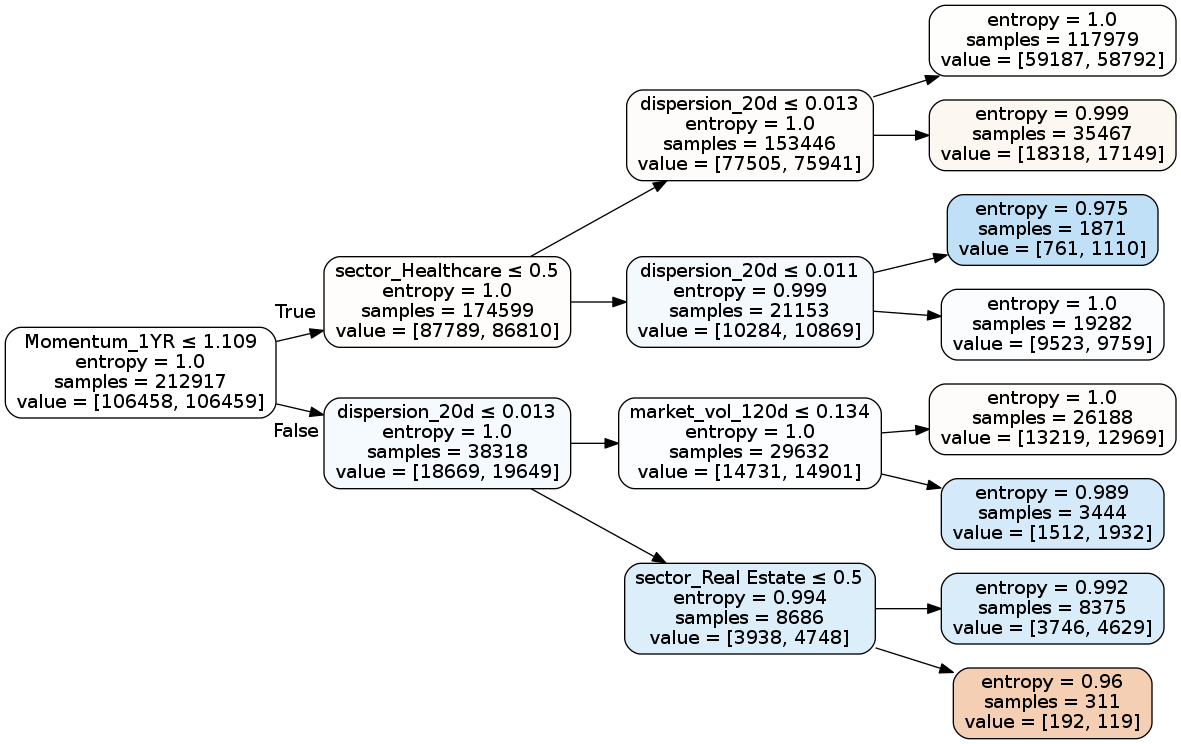

      Feature                                    Importance
 1. dispersion_20d                         (0.46843340608552875)
 2. market_vol_120d                        (0.19358730055081794)
 3. sector_Real Estate                     (0.12813661543951108)
 4. Momentum_1YR                           (0.11211962120010666)
 5. sector_Healthcare                      (0.09772305672403549)
 6. sector_Basic Materials                 (0.0)
 7. weekday                                (0.0)
 8. Overnight_Sentiment_Smoothed           (0.0)
 9. adv_120d                               (0.0)
10. adv_20d                                (0.0)
11. dispersion_120d                        (0.0)
12. market_vol_20d                         (0.0)
13. volatility_20d                         (0.0)
14. is_Janaury                             (0.0)
15. is_December                            (0.0)
16. month_end                              (0.0)
17. sector_Energy                          (0.0)
18. month_start            

In [26]:
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier


# This is to get consistent results between each run.
clf_random_state = 0

simple_clf = DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    random_state=clf_random_state)
simple_clf.fit(X_train, y_train)

display(project_helper.plot_tree_classifier(simple_clf, feature_names=features))
project_helper.rank_features_by_importance(simple_clf.feature_importances_, features)

### Question: Why does dispersion_20d have the highest feature importance, when the first split is on the Momentum_1YR feature?
*#TODO: Put Answer In this Cell.  *

Because splits and importance are determined in different ways. 

In sklearn, feature importance is determined based on Gini Importance, calculated by the weighted decrease in Gini impurity at a node. This means the importance of a feature is affected by the number of samples in the node (ie: if there are only a few samples in a node, then its weighted importance is reduced). 

Splits are determined by which feature has the greatest information gain, calclulated by finding the difference beteween the entropy of the parent node and the sum of the child nodes probability-weighted entopies. This is different than weighting by the number of samples in the node.


### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [27]:
n_days = 10
n_stocks = 500

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [50, 100, 250, 500, 1000]

Recall from the lesson, that we’ll choose a min_samples_leaf parameter to be small enough to allow the tree to fit the data with as much detail as possible, but not so much that it overfits.  We can first propose 500, which is the number of assets in the estimation universe. Since we have about 500 stocks in the stock universe, we’ll want at least 500 stocks in a leaf for the leaf to make a prediction that is representative.  It’s common to multiply this by 2,3,5 or 10, so we’d have min samples leaf of 500, 1000, 1500, 2500, and 5000. If we were to try these values, we’d notice that the model is “too good to be true” on the training data.  A good rule of thumb for what is considered “too good to be true”, and therefore a sign of overfitting, is if the sharpe ratio is greater than 4.  Based on this, we recommend using min_sampes_leaf of 10 * 500, or 5,000.

Feel free to try other values for these parameters, but also keep in mind that making too many small adjustments to hyper-parameters can lead to overfitting even the validation data, and therefore lead to less generalizable performance on the out-of-sample test set.  So when trying different parameter values, choose values that are different enough in scale (i.e. 10, 20, 100 instead of 10,11,12).


In [28]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 5/5 [09:10<00:00, 110.20s/Model]


Let's look at the accuracy of the classifiers over the number of trees.

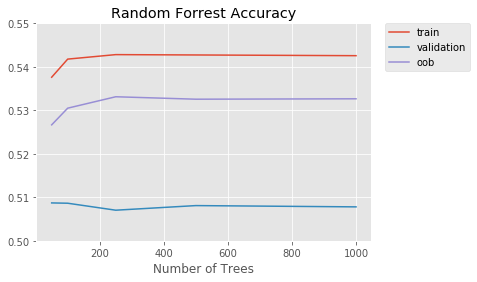

In [31]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

#### Question: 1) What do you observe with the accuracy vs tree size graph? 2) Does the graph indicate the model is overfitting or underfitting? Describe how it indicates this.
*#TODO: Put Answer In this Cell. *

1) The model doesn't increase in accuracy on train or oob sets beyond about 200-250 trees, so no point in training extra trees. And there is no improvement on the validation set, irrespective of the number of trees. 

2) Its likely the model is overfitting as the validation accuracy is worse and diverges from the oob accuracy, which suggests overfitting in the out-of-basket trees. Also, the oob score is only slightly lower than the train score and follows it closely, a sign of potential autocorellation between the out of bag sets and the train sets, resulting overfitting.


Now let's looks at the average feature importance of the classifiers.

In [32]:
print('Features Ranked by Average Importance:\n')
project_helper.rank_features_by_importance(np.average(feature_importances, axis=0), features)

Features Ranked by Average Importance:

      Feature                                    Importance
 1. dispersion_20d                         (0.1269778070278301)
 2. volatility_20d                         (0.12109751092486871)
 3. market_vol_120d                        (0.10610349775271208)
 4. market_vol_20d                         (0.1031284505504851)
 5. Momentum_1YR                           (0.09619459615815973)
 6. dispersion_120d                        (0.07964771723886842)
 7. Overnight_Sentiment_Smoothed           (0.07791967844615746)
 8. Mean_Reversion_Sector_Neutral_Smoothed (0.06975870911774727)
 9. adv_120d                               (0.05918153910377677)
10. adv_20d                                (0.05434312068691877)
11. sector_Healthcare                      (0.03158933275282147)
12. sector_Basic Materials                 (0.012648395225842244)
13. sector_Consumer Defensive              (0.011217900024550611)
14. sector_Industrials                     (0.010608580

You might notice that some of the features of low to no importance. We will be removing them when training the final model.
### Model Results
Let's look at some additional metrics to see how well a model performs. We've created the function `show_sample_results` to show the following results of a model:
- Sharpe Ratios
- Factor Returns
- Factor Rank Autocorrelation

In [29]:
import alphalens as al


all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = get_pricing(
    data_portal,
    trading_calendar,
    all_assets,
    factor_start_date,
    universe_end_date)

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'AI_ALPHA'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = project_helper.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = project_helper.get_factor_returns(factor_data)
    sharpe_ratio = project_helper.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    project_helper.plot_factor_returns(factor_returns)
    project_helper.plot_factor_rank_autocorrelation(factor_data)

#### Results
Let's compare our AI Alpha factor to a few other factors. We'll use the following:

In [30]:
factor_names = [
    'Mean_Reversion_Sector_Neutral_Smoothed',
    'Momentum_1YR',
    'Overnight_Sentiment_Smoothed',
    'adv_120d',
    'volatility_20d']

##### Training Prediction
Let's see how well the model runs on training data.

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

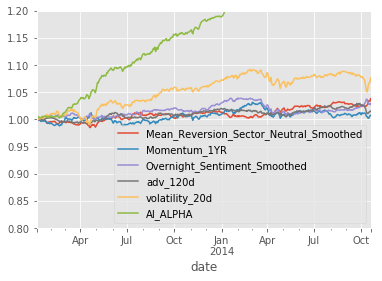

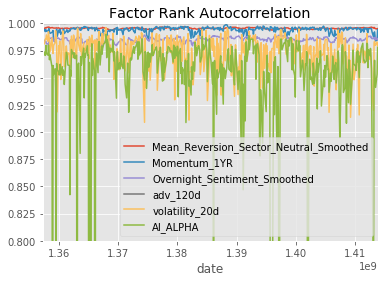

In [35]:
show_sample_results(all_factors, X_train, clf, factor_names)

##### Validation Prediction
Let's see how well the model runs on validation data.

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

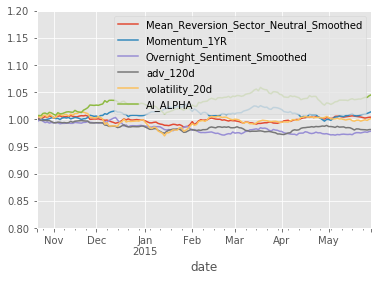

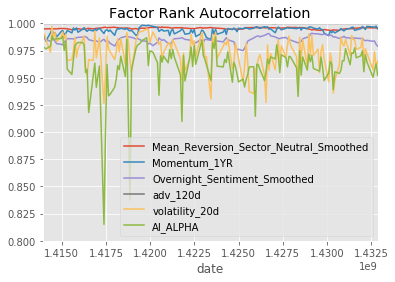

In [36]:
show_sample_results(all_factors, X_valid, clf, factor_names)

So that's pretty extraordinary. Even when the input factor returns are sideways to down, the AI Alpha is positive with Sharpe Ratio > 2. If we hope that this model will perform well in production we need to correct though for the non-IID labels and mitigate likely overfitting.

## Overlapping Samples
Let's fix this by removing overlapping samples. We can do a number of things:

- Don't use overlapping samples
- Use BaggingClassifier's `max_samples`
- Build an ensemble of non-overlapping trees

In this project, we'll do all three methods and compare.
### Drop Overlapping Samples
This is the simplest of the three methods. We'll just drop any overlapping samples from the dataset. Implement the `non_overlapping_samples` function to return a new dataset overlapping samples. 

In [31]:
def non_overlapping_samples(x, y, n_skip_samples, start_i=0):
    """
    Get the non overlapping samples.

    Parameters
    ----------
    x : DataFrame
        The input samples
    y : Pandas Series
        The target values
    n_skip_samples : int
        The number of samples to skip
    start_i : int
        The starting index to use for the data
    
    Returns
    -------
    non_overlapping_x : 2 dimensional Ndarray
        The non overlapping input samples
    non_overlapping_y : 1 dimensional Ndarray
        The non overlapping target values
    """
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    
    # TODO: Implement
    non_overlapping_x = x.loc[x.index.levels[0][start_i::n_skip_samples+1].tolist()]
    non_overlapping_y = y.loc[y.index.levels[0][start_i::n_skip_samples+1].tolist()]
     
    return non_overlapping_x, non_overlapping_y


project_tests.test_non_overlapping_samples(non_overlapping_samples)

Tests Passed


With the dataset created without overlapping samples, lets train a new model and look at the results.

#### Train Model

In [38]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(*non_overlapping_samples(X_train, y_train, 4))
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)

Training Models: 100%|██████████| 5/5 [01:10<00:00, 14.16s/Model]


#### Results

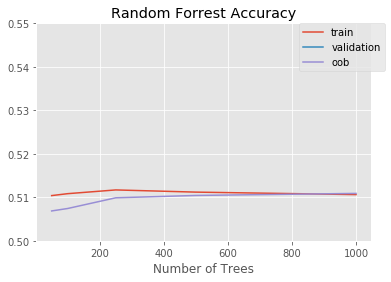

In [39]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [40]:
valid_score

[0.49749647833303112,
 0.49470703914977893,
 0.49345179151731544,
 0.49268469574192109,
 0.49327047797040408]

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

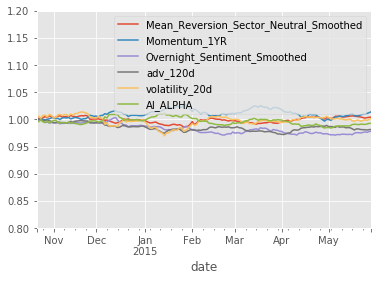

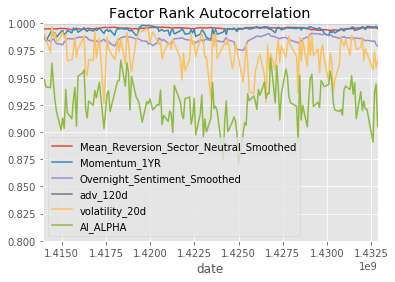

In [41]:
show_sample_results(all_factors, X_valid, clf, factor_names)

This looks better, but we are throwing away a lot of information by taking every 5th row.

### Use BaggingClassifier's `max_samples`
In this method, we'll set `max_samples` to be on the order of the average uniqueness of the labels. Since  `RandomForrestClassifier` does not take this param, we're using `BaggingClassifier`. Implement `bagging_classifier` to build the bagging classifier.

In [42]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


def bagging_classifier(n_estimators, max_samples, max_features, parameters):
    """
    Build the bagging classifier.

    Parameters
    ----------
    n_estimators : int 
        The number of base estimators in the ensemble
    max_samples : float 
        The proportion of input samples drawn from when training each base estimator
    max_features : float 
        The proportion of input sample features drawn from when training each base estimator
    parameters : dict
        Parameters to use in building the bagging classifier
        It should contain the following parameters:
            criterion
            min_samples_leaf
            oob_score
            n_jobs
            random_state
    
    Returns
    -------
    bagging_clf : Scikit-Learn BaggingClassifier
        The bagging classifier
    """
    
    required_parameters = {'criterion', 'min_samples_leaf', 'oob_score', 'n_jobs', 'random_state'}
    assert not required_parameters - set(parameters.keys())
    
    # TODO: Implement
    # Get the parameters from the dict:
    criterion = parameters['criterion']
    min_samples_leaf = parameters['min_samples_leaf']
    oob_score = parameters['oob_score']
    n_jobs = parameters['n_jobs']
    random_state = parameters['random_state']
    
    # Set the base estimator
    base_clf = DecisionTreeClassifier(criterion=criterion, 
                                      max_features=max_features,
                                      min_samples_leaf=min_samples_leaf)
    
    # Bagging classifier
    bagging_clf = BaggingClassifier(base_estimator=base_clf,
                                    n_estimators=n_estimators,
                                    max_samples=max_samples,
                                    bootstrap=True,
                                    oob_score=oob_score,
                                    n_jobs=n_jobs,
                                    verbose=0,
                                    random_state=random_state)
    
    bagging_clf.fit(X_train, y_train)
    
    return bagging_clf

project_tests.test_bagging_classifier(bagging_classifier)

Tests Passed


With the bagging classifier built, lets train a new model and look at the results.
#### Train Model

In [43]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = bagging_classifier(n_trees, 0.2, 1.0, clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)

Training Models: 100%|██████████| 5/5 [28:30<00:00, 342.16s/Model]


#### Results

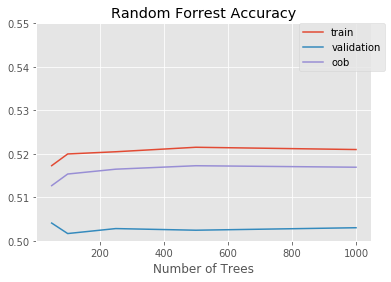

In [44]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

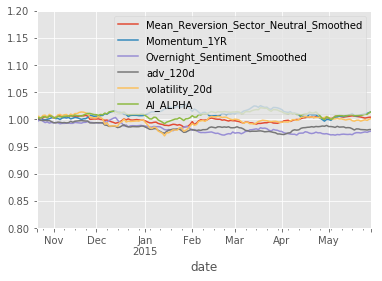

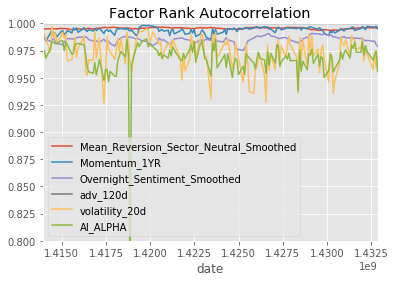

In [45]:
show_sample_results(all_factors, X_valid, clf, factor_names)

This seems much "better" in the sense that we have much better fidelity between the three.


### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [32]:
import abc

from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch


class NoOverlapVoterAbstract(VotingClassifier):
    @abc.abstractmethod
    def _calculate_oob_score(self, classifiers):
        raise NotImplementedError
        
    @abc.abstractmethod
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        raise NotImplementedError
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

You might notice that two of the functions are abstracted. These will be the functions that you need to implement.
#### OOB Score
In order to get the correct OOB score, we need to take the average of all the estimator's OOB scores. Implement `calculate_oob_score` to calculate this score.

In [33]:
def calculate_oob_score(classifiers):
    """
    Calculate the mean out-of-bag score from the classifiers.

    Parameters
    ----------
    classifiers : list of Scikit-Learn Classifiers
        The classifiers used to calculate the mean out-of-bag score
    
    Returns
    -------
    oob_score : float
        The mean out-of-bag score
    """
    
    # TODO: Implement
    oob = 0
    for clf in classifiers:
        oob = oob + clf.oob_score_
        
    return oob / len(classifiers)


project_tests.test_calculate_oob_score(calculate_oob_score)

Tests Passed


#### Non Overlapping Estimators
With `calculate_oob_score` implemented, let's create non overlapping estimators. Implement `non_overlapping_estimators` to build non overlapping subsets of the data, then run a estimator on each subset of data.

In [36]:
def non_overlapping_estimators(x, y, classifiers, n_skip_samples):
    """
    Fit the classifiers to non overlapping data.

    Parameters
    ----------
    x : DataFrame
        The input samples
    y : Pandas Series
        The target values
    classifiers : list of Scikit-Learn Classifiers
        The classifiers used to fit on the non overlapping data
    n_skip_samples : int
        The number of samples to skip
    
    Returns
    -------
    fit_classifiers : list of Scikit-Learn Classifiers
        The classifiers fit to the the non overlapping data
    """
    
    # TODO: Implement    
    fit_classifiers = []
    for i in range(n_skip_samples):
        non_overlap_x, non_overlap_y = non_overlapping_samples(x, y, n_skip_samples, start_i=i)
        fit_classifiers.append(classifiers[i].fit(non_overlap_x, non_overlap_y))

    return fit_classifiers


project_tests.test_non_overlapping_estimators(non_overlapping_estimators)

Tests Passed


In [37]:
class NoOverlapVoter(NoOverlapVoterAbstract):
    def _calculate_oob_score(self, classifiers):
        return calculate_oob_score(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        return non_overlapping_estimators(x, y, classifiers, n_skip_samples)

Now that we have our `NoOverlapVoter` class, let's train it.

#### Train Model

In [38]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|██████████| 5/5 [04:43<00:00, 56.70s/Model]


#### Results

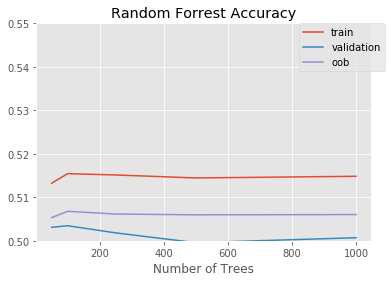

In [39]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [ ]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [41]:
n_trees = 500

clf = RandomForestClassifier(n_trees, **clf_parameters)
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

NoOverlapVoter(estimator=None, n_skip_samples=4, voting='soft')

### Results
#### Accuracy

In [42]:
print('train: {}, oob: {}, valid: {}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.oob_score_))

train: 0.5141017391753594, oob: 0.511164730330967, valid: 0.5086740848732072


#### Train

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

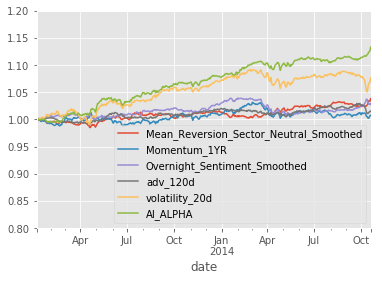

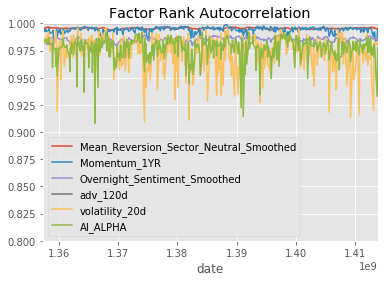

In [43]:
show_sample_results(all_factors, X_train, clf_nov, factor_names)

#### Validation

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

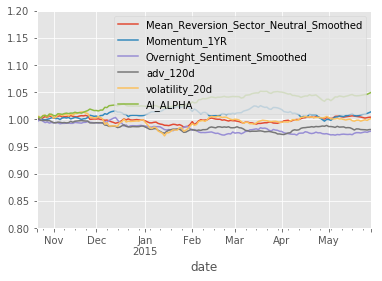

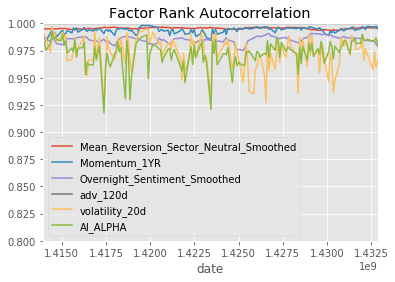

In [44]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

#### Test

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

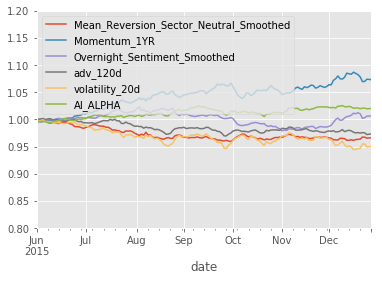

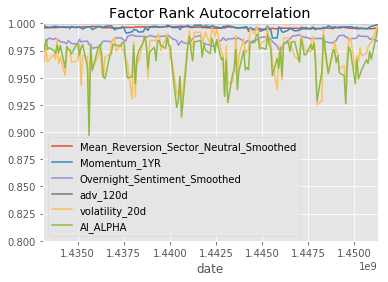

In [45]:
show_sample_results(all_factors, X_test, clf_nov, factor_names)

So, hopefully you are appropriately amazed by this. Despite the significant differences between the factor performances in the three sets, the AI APLHA is able to deliver positive performance.

## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.